In [10]:
#%matplotlib inline

from lxml import html
import re
from bs4 import BeautifulSoup
import time
import requests
import json
import pandas as pd
import numpy as np

from __future__ import division

import matplotlib

import matplotlib.pyplot as plt

plt.style.use('seaborn-white')

import pylab
pylab.ion()

# Get the data

This is the code to call the Politifact API and download the full dataset. For convenience I only saved the tags I needed. The data are saved in a small 3MB json file. 

In [313]:
def clean_str(str):
    str=str.replace('&quot;','"').replace('&quot;','"').replace('<p>','').replace('</p>','')
    str=str.replace('\r\n','').replace('&nbsp;','').replace('<div>','').replace('</div>','')
    return str.replace('&rsquo;',"\'")

In [314]:
def politifact_query(n, offset):
    url_base='http://www.politifact.com/api/v/2/statementlist/?order_by=-ruling_date&format=xml&'
    url = url_base+'limit='+str(n)+'&offset='+str(offset)
    page=requests.get(url)
    soup = BeautifulSoup(page.content, 'xml')
    out=[]
    for idx,tag in enumerate(soup.find_all("statement")):
        statement = clean_str(tag.text)
        score=int(re.findall(r'\d+', str(soup.find_all("ruling")[2*idx].find('id')))[0])
        speaker=re.findall(r'<name_slug>(.*?)</name_slug>',str(soup))[idx]
        date = re.findall(r'<statement_date>(.*?)</statement_date>',str(soup))[idx]
        party= re.findall(r'<party_slug>(.*?)</party_slug>',str(soup))[idx]
        my_dict = {'statement': statement,'score':score,'speaker': speaker, 'date': date,'party': party}
        out.append(my_dict)
    return out

In [ ]:
count = 0
data = []
batch = 5
while (count < 14270):
    out = politifact_query(batch, count)
    data+=out
    count+=batch
    if count%100==0:
        print count

In [373]:
with open('politifact.json', 'w') as f:
    json.dump(data, f)

# Plot I

Simple plot to compare the rate at which democrats and republican lie. The scores go from 1 to 6, 1 being truth, 6 being outlandish falsehood. 

In [2]:
df=pd.read_json('politifact.json')
pol_data=df.copy()
pol_data=pol_data[pol_data['score'].isin(range(1,7))]

In [5]:
temp_mean=pol_data.groupby('party', as_index=False)['score'].mean()
temp_mean[temp_mean['party'].isin(['republican','democrat'])]

,party,score
6,democrat,2.916705
21,republican,3.453100


In [6]:
temp_std=pol_data.groupby('party', as_index=False)['score'].var()
temp_std[temp_std['party'].isin(['republican','democrat'])]

,party,score
6,democrat,2.133596
21,republican,2.334190


In [7]:
np.sqrt(2.133596)

1.4606834016993553

In [8]:
np.sqrt(2.334190)

1.5278056159079925

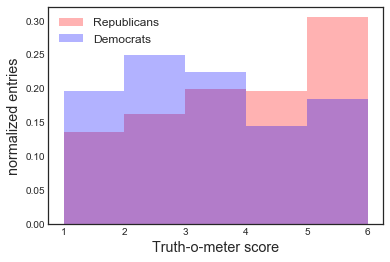

In [57]:
fig, ax = plt.subplots()
plt.hist( pol_data[pol_data['party']=='republican']['score'].values,[1,2,3,4,5,6], color='r', 
         alpha = 0.3, normed=True, label='Republicans')
plt.hist( pol_data[pol_data['party']=='democrat']['score'].values,[1,2,3,4,5,6], color='b',
         alpha = 0.3, normed=True, label='Democrats')
legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
ax.set_xlabel('Truth-o-meter score',fontsize='x-large')
ax.set_ylabel('normalized entries',fontsize='x-large')
fig.show()

# Plot II

I show tf-idf (Term Fequency - Inverse Document Frequency, https://en.wikipedia.org/wiki/Tf%E2%80%93idf) statistics of words in true and false statements for democrats and republicans

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
from scipy.sparse import csr_matrix

In [118]:
stop_words = stopwords.words('english') + list(punctuation)
 
def tokenize(text):
    words = word_tokenize(text)
    return [w.lower() for w in words]

def score_text(text):
    X = tfidf.transform([text])
    return [[word, X[0, tfidf.vocabulary_[word]]] for word in tokenize(text)]

def score_corpus(corpus,topn=25):
    score =csr_matrix(np.zeros((1,len(vocabulary))))
    for text in corpus:
        X =  tfidf.transform([text])
        score += X[0,:]
    score = score.toarray()[0]/len(corpus)
    ind = score.argsort()[-topn:][::-1]
    out = [[dictionary[idx] , score[idx]] for idx in ind]
    return out

def diff_corpus(corpus1,corpus2,topn=30):
    score1 =csr_matrix(np.zeros((1,len(vocabulary))))
    for text in corpus1:
        X =  tfidf.transform([text])
        score1 += X[0,:]
    score2 =csr_matrix(np.zeros((1,len(vocabulary))))
    for text in corpus2:
        X =  tfidf.transform([text])
        score2 += X[0,:]
    score = score1.toarray()[0]/len(corpus1)-score2.toarray()[0]/len(corpus2)
    ind_max = score.argsort()[-topn:][::-1]
    ind_min = score.argsort()[:topn]
    out = [[[dictionary[idx] , score[idx]] for idx in ind_max],[[dictionary[idx] , -score[idx]] for idx in ind_min]]
    return out

def plot_tfidf_classfeats_h(dfs, labels, color='k',alpha = 0.5):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(5, 4), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=12)
        ax.set_title( labels[i], fontsize=14)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, [v[1] for v in df], align='center', color=color, alpha=alpha)
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels([v[0] for v in df])
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [78]:
df=pd.read_json('politifact.json')
pol_data=df.copy()
pol_data=pol_data[pol_data['score'].isin(range(1,7))]

In [79]:
texts = pol_data['statement'].values
# build the vocabulary 
vocabulary = set([word for text in texts for word in tokenize(text)])

In [80]:
# Fit the TfIdf model
tfidf = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenize, vocabulary=vocabulary)
tfidf.fit([text for text in texts])

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u"you're", u"you've", u"you'll", u"you'd", u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u"she's", u'her', u'hers', u'herself', u'it', u"it's", u'its', u'itself', u'th...'-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~'],
        strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x11cab7050>, use_idf=True,
        vocabulary=set([u'pacemaker', u'1,800', u'r', u'1,773', u'foul', u'narcotic', u'four', u'jihad', u"'bridge", u'compliance', u'towns',

In [81]:
# build a dictionary
values = list(vocabulary)
keys = [tfidf.vocabulary_[word] for word  in values]
dictionary = dict(zip(keys, values))

In [92]:
pol_data_T_dem=pol_data[(pol_data['score']<=3)&(pol_data['party']=='democrat')].reset_index()
pol_data_F_dem=pol_data[(pol_data['score']>=3)&(pol_data['party']=='democrat')].reset_index()
pol_data_T_rep=pol_data[(pol_data['score']<=3)&(pol_data['party']=='republican')].reset_index()
pol_data_F_rep=pol_data[(pol_data['score']>=3)&(pol_data['party']=='republican')].reset_index()
print(len(pol_data_T_dem))
print(len(pol_data_F_dem))
print(len(pol_data_T_rep))
print(len(pol_data_F_rep))

2930
2421
3074
4317


In [99]:
true_texts_dem = pol_data_T_dem['statement'].values
false_texts_dem = pol_data_F_dem['statement'].values
true_texts_rep = pol_data_T_rep['statement'].values
false_texts_rep = pol_data_F_rep['statement'].values
tfidf_plot_dem=diff_corpus(true_texts_dem,false_texts_dem,10)
tfidf_plot_rep=diff_corpus(true_texts_rep,false_texts_rep,10)

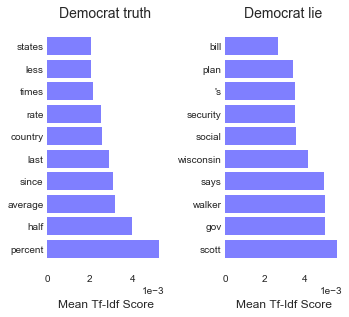

In [120]:
plot_tfidf_classfeats_h(tfidf_plot_dem,['Democrat truth','Democrat lie'],'b')

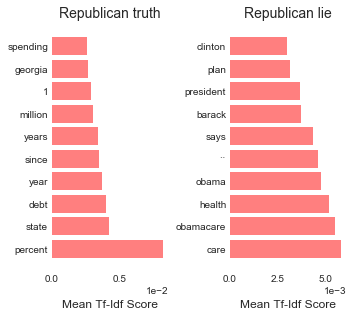

In [119]:
plot_tfidf_classfeats_h(tfidf_plot_rep,['Republican truth','Republican lie'],'r')